In [2]:
##### MODIFY HERE #####
# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# specify site name
site_name = 'Wolverine'
# path where figures will be saved
figures_out_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/' + site_name + '/figures/' 
# path to snowline files
sl_est_path = figures_out_path +'../imagery/snowlines/' 
# path where filtered snowlines will be saved
out_path = sl_est_path 
# path to USGS mass balance data/ELA csvs 
# If no USGS files, set usgs_path=None
usgs_path = None #'/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
#######################

# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime
import seaborn as sns
from scipy.stats import median_abs_deviation as mad
from scipy.interpolate import interp1d

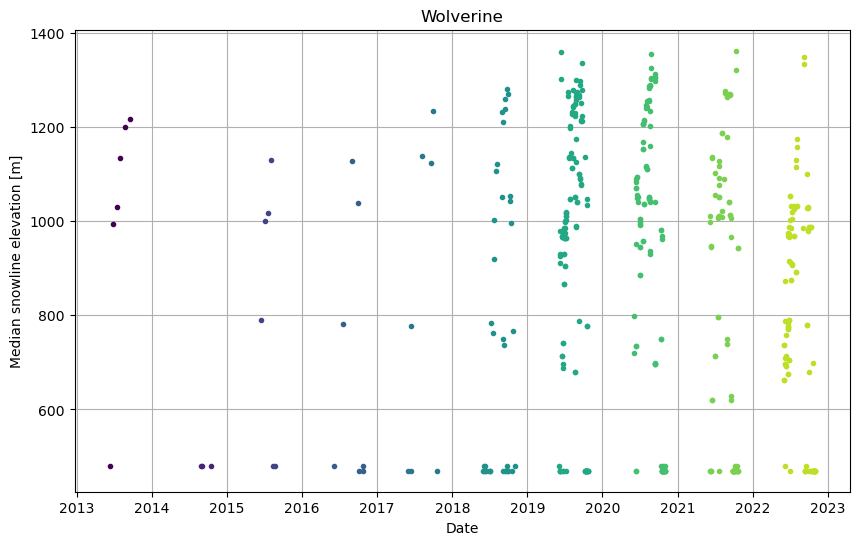

In [4]:
# -----Compile snowline files
sl_est_fns = glob.glob(sl_est_path + '*snowline.csv')
# compile all snowline files into one DataFrame
sl_est_full = pd.DataFrame()
for fn in sl_est_fns:
    # read file
    if 'csv' in fn:
        sl_est = pd.read_csv(fn)
    elif 'pkl' in fn:
        sl_est = pickle.load(open(fn, 'rb'))
    # concatenate to df
    sl_est_full = pd.concat([sl_est_full, sl_est])
sl_est_full = sl_est_full.reset_index(drop=True).sort_values(by=['datetime']) # renumber, sort by date

# -----Reformat snowlines dataframes
# unify datetime datatypes
sl_est_full['datetime'] = sl_est_full['datetime'].astype('datetime64[ns]')
# add month column
sl_est_full['month'] = [x.month for x in sl_est_full['datetime']]
# add year column
sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]

# extract all unique years
years = np.unique(sl_est_full['year'])
# set datetime as index
sl_est_full.index = sl_est_full['datetime']

# plot all snowline elevations 
fig = plt.figure(figsize=(10,6))
cmap = plt.cm.viridis
for i, year in enumerate(years):
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    plt.plot(sl_est_year['datetime'], sl_est_year['snowlines_elevs_median_m'], '.', color=cmap(i/len(years)))
plt.grid()
plt.ylabel('Median snowline elevation [m]')
plt.xlabel('Date')
plt.title(site_name)
plt.show()

#### Filter using gradient in median snowline elevations

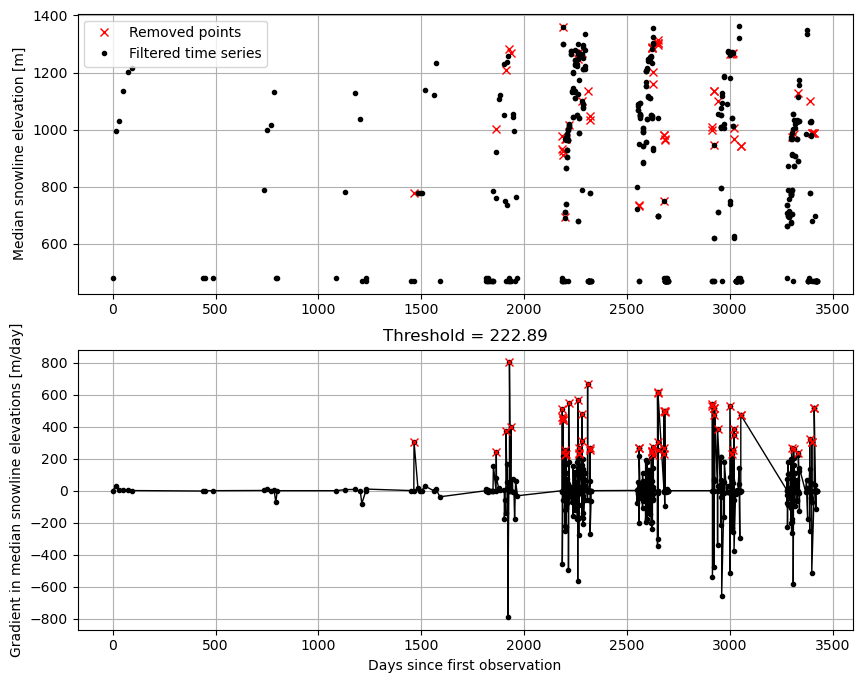

In [98]:
# -----Create array of days since first observation date
min_date = np.nanmin(sl_est_full['datetime'].values.astype('datetime64[D]'))
max_date = np.nanmax(sl_est_full['datetime'].values.astype('datetime64[D]'))
sl_days = (sl_est_full['datetime'].values.astype('datetime64[D]') - min_date).astype(int)
sl = sl_est_full['snowlines_elevs_median_m'].values

# -----Filter snowline elevations using gradient in median snowline elevations
# define threshold based on site elevation range
min_elev, max_elev = np.nanmin(sl), np.nanmax(sl)
threshold = (max_elev - min_elev)*0.25 # gradient threshold
# calculate change in snow elevation between each data point
Iremove = [] # indices of snowlines to remove
sl_gradient = np.zeros(len(sl)) # [m/day]
for i in np.arange(1,len(sl_gradient)):
    # if previous point was filtered out, use second to last observation to calculate gradient
    if i-1 in Iremove:
        if sl_days[i]!=sl_days[i-2]: # if previous point is on a different day
            sl_gradient[i] = (sl[i] - sl[i-2]) / (sl_days[i] - sl_days[i-2])
        else: # if previous point is on the same day
            sl_gradient[i] = (sl[i] - sl[i-2])
    # otherwise, use previous observation to calculate gradient
    else:
        if sl_days[i]!=sl_days[i-1]: # if previous point is on a different day
            sl_gradient[i] = (sl[i] - sl[i-1]) / (sl_days[i] - sl_days[i-1])
        else:
            sl_gradient[i] = (sl[i] - sl[i-1])
    # if gradient exceeds threshold, add to list of filter indices 
    if (sl_gradient[i] > threshold):
        Iremove += [i]
# Apply filter
sl_filt = np.delete(sl, Iremove)
sl_days_filt = np.delete(sl_days, Iremove)
sl_removed = sl[Iremove]
sl_days_removed = sl_days[Iremove]

# -----Plot results
fig, ax = plt.subplots(2,1, figsize=(10,8))
ax[0].plot(sl_days_removed, sl_removed, 'xr', label='Removed points')
ax[0].plot(sl_days_filt, sl_filt, '.k', label='Filtered time series')
ax[0].set_ylabel('Median snowline elevation [m]')
ax[0].grid()
ax[0].legend(loc='best')
ax[1].plot(sl_days, sl_gradient, '.-k', linewidth=1)
ax[1].plot(sl_days_removed, sl_gradient[Iremove], 'xr')
ax[1].set_ylabel('Gradient in median snowline elevations [m/day]')
ax[1].set_xlabel('Days since first observation')
ax[1].set_title('Threshold = '+str(np.round(threshold,2)))
ax[1].grid()

#### Apply Butterworth low-pass filter

Adapted from [Neha Jirafe's Medium article](https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7)

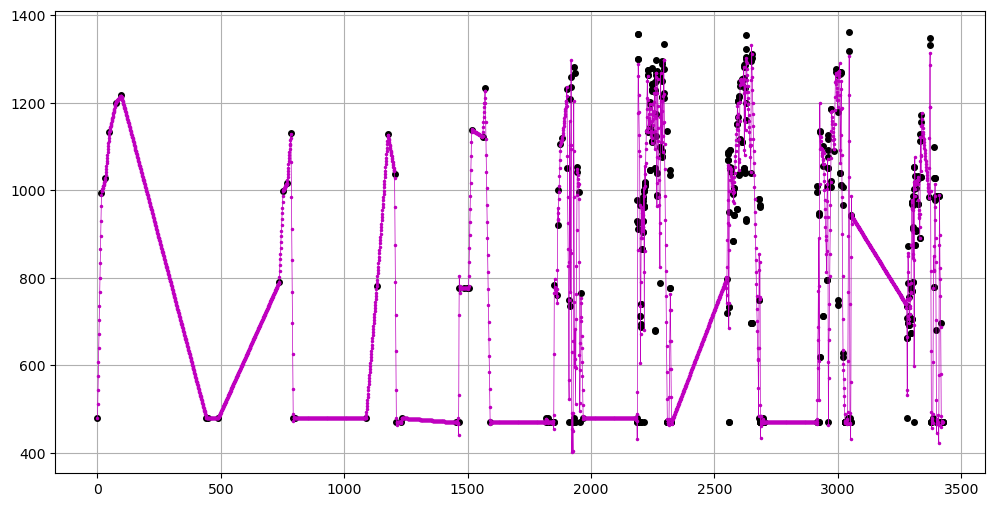

In [71]:
from scipy.signal import butter,filtfilt

# create array of all days in time series
min_date = np.nanmin(sl_est_full['datetime'].values.astype('datetime64[D]'))
max_date = np.nanmax(sl_est_full['datetime'].values.astype('datetime64[D]'))
days = (np.arange(min_date, max_date) - min_date).astype(int)

# interpolate snowline at each day
sl_days = (sl_est_full['datetime'].values.astype('datetime64[D]') - min_date).astype(int)
f = interp1d(sl_days, 
             sl_est_full['snowlines_elevs_median_m'].values)
sl_interp = f(days)
# remove NaNs
for i in np.arange(0,len(sl_interp)):
    if np.isnan(sl_interp[i]):
        sl_interp[i] = sl_interp[i-1]

# Filter requirements
n = len(days)   # number of samples
fs = 1          # sample rate [1/d]
cutoff = 0.3    # desired cutoff frequency of the filter [1/d], must be betwen 0 and 1
nyq = 0.5 * fs  # Nyquist Frequency
order = 3       # sine wave can be approx represented as polynomial

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Filter the data
y = butter_lowpass_filter(sl_interp, cutoff, fs, order)

# plot raw, interpolated, and filtered data
fig = plt.figure(figsize=(12,6))
# plt.plot(days, sl_interp, '.c')
plt.plot(sl_days, sl_est_full['snowlines_elevs_median_m'].values, '.k', markersize=8)
plt.plot(days, y, '.-m', markersize=3, linewidth=0.5)
plt.grid()
plt.show()

#### Align snowline elevation peaks and minimums for each year

In [3]:
# Define function to calculate running median
from collections import deque
from bisect import insort, bisect_left
from itertools import islice
def running_median(x, N):
    '''
    Calculate running median. 
    Adapted from Peter Otten: https://stackoverflow.com/questions/37671432/how-to-calculate-running-median-efficiently
    
    Parameters
    ----------
    x: numpy.array
        input array of values
    N: int or float
        window size over which to calculate running median
        
    Returns
    ----------
    x_moving_median: np.array
        moving median of x with a window of N
    '''
    seq = iter(x)
    d = deque()
    s = []
    x_moving_median = []
    for item in islice(x, N):
        d.append(item)
        insort(s, item)
        x_moving_median.append(s[len(d)//2])
    m = N // 2
    for item in seq:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        x_moving_median.append(s[m])
    # adjust values to original x where median is invalid
    x_moving_median = np.concatenate((x[0:int((N-1)/2)], 
                                      x_moving_median[int(N*2)-1:], 
                                      x[-int((N-1)/2):]))
    return x_moving_median

5 [0, 6]
2 [0, 3]
3 [0, 6]
3 [0, 4]
7 [1, 9]
28 [25, 29]
9 [6, 18]
66 [7, 84]
71 [68, 73]
61 [0, 62]


/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


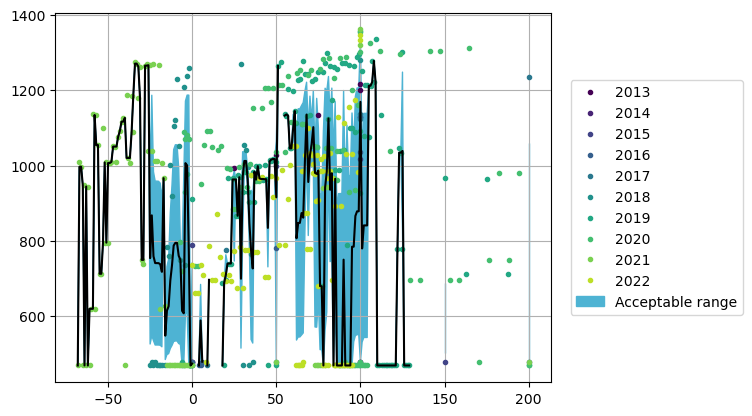

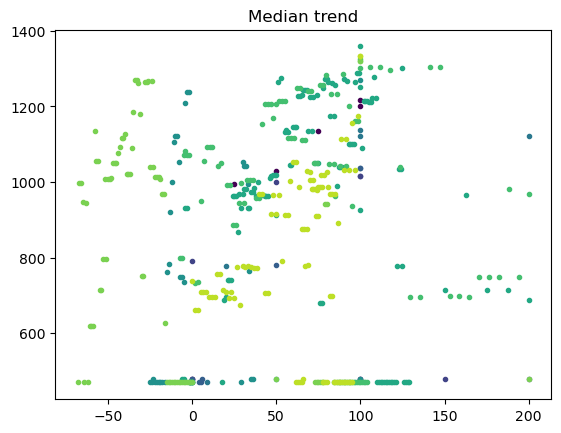

In [94]:
# ----Set up figure
# fig = plt.figure(figsize=(20, 6))
# plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
# spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2.5])
# ax1 = fig.add_subplot(spec[0, 0])
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Median snowline elevations [m]')
# ax1.grid()
# ax2 = fig.add_subplot(spec[0, 1])
# ax2.set_xlabel('Date')
# ax2.grid()

fig1, ax1 = plt.subplots(1, 1)
plt.style.use('default')
col = plt.cm.viridis

fig2, ax2 = plt.subplots(1, 1)

# -----Initialize variables
df_full = pd.DataFrame()
days_new_full = []
snowline_elevs_full = []
sl_min = np.nanmin(sl_est_year['snowlines_elevs_median_m'].values) # minimum snowline elevation for all dates

# -----Loop through years
for i, year in enumerate(years):
    
    # subset snowlines by year
    sl_est_year = sl_est_full.loc[sl_est_full['year']==year]
    # grab day of year (DOY) for each date
    sl_est_year_DOY = (sl_est_year['datetime'].values.astype('datetime64[D]') 
                         - np.datetime64(str(year)+'-01-01')).astype(int)
    sl_interp = sl_est_year['snowlines_elevs_median_m'].values
    days = sl_est_year_DOY
    # create array of days between minimum and maximum DOY
    # days = np.arange(np.nanmin(sl_est_year_DOY), np.nanmax(sl_est_year_DOY)).astype(int)
    # # interpolate snowline at each day
    # f = interp1d(sl_est_year_DOY, sl_est_year['snowlines_elevs_median_m'])
    # sl_interp = f(days)
    
    # calculate moving median 
    N = 3 # window size
    sl_interp_med = running_median(sl_interp, N)
    
    # shift into "relative space" where min and max snowline elevations are ~aligned for all years
    max_position = 100 # "day" where all maximum snowline elevations will be aligned
    min_positions = [0, 200] # "days" where all minimum snowline elevations will be aligned
    Imax = np.argwhere(sl_interp_med==np.nanmax(sl_interp_med))[-1][0] # index where maximum snowline elevation occurs
    Imins = [0,len(sl_interp)] # index where minimum snowline elevation occurs - start with min and max indices
    if any(sl_interp_med[0:Imax] == sl_min): # if any snowline elevs equal minimum BEFORE reaching maximum
        Imins[0] = np.argwhere(sl_interp_med[0:Imax]==sl_min)[-1][0] # minimum before max snowline elev
    if any(sl_interp_med[Imax:] == sl_min): # if any snowline elevs equal minimum AFTER reaching maximum
        Imins[1] = np.argwhere(sl_interp_med[Imax:]==sl_min)[0][0] + Imax # minimum after max snowline elev
    print(Imax, Imins)
    # create new days array
    days_new = np.zeros(len(days))
    # align first minimum and maximum snowline elevations
    days_new[Imins[0]:Imax] = [i*(max_position - min_positions[0]) for i in np.linspace(0, 1, num=Imax-Imins[0])]
    # align maximum and second minimum snowlines
    days_new[Imax:Imins[1]] = [i*(min_positions[1]-max_position)+max_position for i in np.linspace(0, 1, num=Imins[1]-Imax)]
    # align points outside the minimum snowline elevations
    days_new[0:Imins[0]] = [i-Imins[0] for i in np.arange(0,Imins[0])]
    days_new[Imins[1]:] = [Imins[1]+i for i in np.arange(0,len(days)-Imins[1])]
    # calculate magnitude shift from original days
    days_shift = days_new - days
    
    # plot
    ax1.plot(days_new, sl_interp, '.', color=col(i/len(years)), label=year)
    ax2.plot(days_new, sl_interp_med, '.', color=col(i/len(years)), label=year)

    # add to full data variables
    days_new_full = np.concatenate((days_new_full, days_new))
    snowline_elevs_full = np.concatenate((snowline_elevs_full, sl_interp_med))
    df = pd.DataFrame({'year': [year],
                       'days': [days],
                       'days_new': [days_new],
                       'sl_est': [sl_interp],
                      })
    df_full = pd.concat([df_full, df])
    
# adjust full dataframe
df_full = df_full.reset_index(drop=True)

# sort days and snowlines by date
Isort = np.argsort(days_new_full)
days_new_full_sort = days_new_full[Isort]
snowline_elevs_full_sort = snowline_elevs_full[Isort]

# characterize acceptable range
unique_days = np.unique(np.round(days_new_full_sort))
# weeks = np.arange(np.fix(unique_days[0]/7), np.round(unique_days[-1]/7))
med = np.zeros(len(unique_days))
IQR_min, IQR_max = np.zeros(len(unique_days)), np.zeros(len(unique_days))
for i, day in enumerate(unique_days):
    # Iweek = np.argwhere((days_new_full_sort/7 > weeks[i]) & (days_new_full_sort/7 < weeks[i+1]))
    Iday = np.argwhere(days_new_full_sort==day)
    med[i] = np.nanmedian(snowline_elevs_full_sort[Iday])
    IQR_min[i] = iqr(snowline_elevs_full_sort[Iday], rng=(10,50), nan_policy='omit')
    IQR_max[i] = iqr(snowline_elevs_full_sort[Iday], rng=(50,90), nan_policy='omit')
    
ax1.fill_between(unique_days, med-IQR_min, med+IQR_max, color='#4eb3d3', label='Acceptable range')
ax1.plot(unique_days, med, '-k')
ax1.grid()
ax1.legend(loc='center right', bbox_to_anchor=[1.2, 0.4, 0.2, 0.2])
ax2.set_title('Median trend')
plt.show()

In [81]:
np.argwhere(sl_interp_med[0:Imax]==sl_min)[-1][0]

13